<h2 style="text-align: center;">Illuminated Spheres with Relfection and Refraction: Scene 1</h2>
<h3 style="text-align: center;">Ross Beveridge, November 14, 2017</h3>
<p> </p>
<p>This notebook is a rather complete illustration of many key concepts in CS 410 pertaining to Ray Tracing.  This example consists of one semi-transparent sphere partially occluding 3 brightly colored spheres forming a triangle pattern.</p>
<p>The general concpets illustrated here include:</p>
<ul>
<li>A camera object/model fully specifying how a camera views a 3D scene.</li>
<li>A ray object defined by a point of origination and a direction.</li>
<li>A scene consisting of multiple 3D objects, more specifically spheres.  </li>
<li>Materials used to specify how light interacts with an object's surface.</li>
<li>Point light sources</li>
<li>A SageMath enabled 3D visualization of the scene specification </li>
<li>Code to efficiently detect ray sphere intersections</li>
<li>Code to support recursive ray tracing with reflection</li>
<li>Code to shoot a refractioh ray through a semi-transparent sphere</li>
<li>Code to render scenes at user specified resolutions with both reflection and refraction</li>
</ul>
<p>This notebook should be used to study and experiment with these components in order to better understand how all of these different elments of a ray tracer work.  The design is by no means optimized.  However, it is compact enough to fit everything into a single notebook. </p>
<p>It will be common to see slightly different versions of this notebook denoted Scene01, etc, where that actual objects, camera, lights and materials are modified to produce a different scene.  </p>
<p>The first bit of code that follows is book keeping to help setup libraries and display defaulst.  Read on below to get more about the substance of this ray tracer.</p>

In [235]:
import numpy as np
from sage.repl.image import Image
from sage.plot.plot3d.shapes import *
from sage.plot.plot3d.base import SHOW_DEFAULTS
SHOW_DEFAULTS['aspect_ratio'] = (1,1,1)
SHOW_DEFAULTS['frame_aspect_ratio'] = (1,1,1)
SHOW_DEFAULTS['perspective_depth'] = false

<p>The first object class models a camera.  A camera specification includes:</p>
<ul>
<li>eye: the 3D position of the camera focal point in the world.</li>
<li>look: where the camera is looking, a 3D point in the world.</li>
<li>up: camera's should be held level relative to gravity as defined by the up vector.</li>
<li>The bounds of the rectangular bounded image on the infinite image plane.</li>
<li>The coordinate position of the near clipping (image) plane, e.g. -10 means ten units in front of the focal point.</li>
<li>The coordinate position of the far clipping plane, e.g. -100 means one hundred units in front of the focal point.</li>
<li>The pixel width and height. In other words, resolution, in other words how many pixel (samples) across and down.</li>
</ul>
<p>Because the three basis vectors defining the camera optical axis, horizontal axis and vertical axis are so fundamental to the camera object, they are created at the time a camera object instance is created. </p>
<p>This notebook uses one dimensional numpy arrays extensively, including for all 3D coordinates of points and all 3D vectors.  Also, the act of adjusting the length of a vector such that is is unity is some common that a function for this operation is defined right here at the top of the notebook.  </p>
<p>Because the notebook standardizes on numpy arrays the numpy support for common operations, notabley cross products and dot products, are used.</p>

In [236]:
def make_unit(x) :
    return x / np.linalg.norm(x)
    
class Camera :
    def __init__(self, eye, look, up, bnds, near, far, width, height) :
        self.eye   = np.array(eye)
        self.look  = np.array(look)
        self.up    = np.array(up)
        self.umin  = bnds[0]
        self.umax  = bnds[1]
        self.vmin  = bnds[2]
        self.vmax  = bnds[3]
        self.near  = near
        self.far   = far
        self.width = width
        self.height = height
        self.setupUVW()
        
    def setupUVW(self) :
        Wv = make_unit(self.eye - self.look)   
        Uv = make_unit(np.cross(self.up, Wv))    
        self.V = np.cross(Wv,Uv)
        self.U = Uv
        self.W = Wv

<p>The ray class follows our standard definition of a ray as a pair: a point of origination L and a direction D.</p>
<p>The ray object also provides a means of keeping track of the closet sphere yet found. There are a variety of ways to think about this process, but perhaps the simplest is cacheing. Much of the work done in ray tracing involves finding interesections between rays and obejcts; after going to all that effort, it is wise to keep the best result. In other words the closest object - provided the ray intersects any objects at all. Specifically, a ray has variables to keep track of the best sphere, meaning closest, and also the associated t-value and 3D point of intersection for this best sphere.</p>
<p>In the method sphere_test arises a good example of a practical complication. Namely, when launching a ray from a point on a sphere, it is highly annoying of the code reports that the ray intersects that self-same sphere. One way to avoid this problem is to explicitly record whether a ray is being launched from a sphere, and if so, which sphere. However, this involves a lot of extra mechanism.  A simpler 'hack' is to ignore an intersection if the t-value is very small, since very small indicates in all likelihood the intersection is with the same object as that from which the ray is being launched.  This issue does not arise in ray casting, but arises quickly when doing recursive ray tracing. Therefore, not the two part test used to determine if a particular sphere is the best.</p>

In [237]:
class Ray :
    def __init__(self, L, D) :
        self.L = np.array(L)
        self.D = make_unit(np.array(D))
        self.best_t = float('inf')
        self.best_sph = None
        self.best_pt = None
       
    def sphere_test(self, sph) :
        Tv   = np.array(sph.C - self.L)
        v    = np.dot(Tv, self.D)
        csq  = np.dot(Tv, Tv)
        disc = sph.r^2 - (csq - v^2)
        if (disc > 0) :
            tval = v - sqrt(disc)
            if (tval < self.best_t) and (tval > 0.001) :
                self.best_t   = tval
                self.best_sph = sph
                self.best_pt  = self.L + tval * self.D       
            return True
        else :
            return False

<p>The object class used for spheres is named 'globe' in order to avoid name collisions.  In particular, there is already a sphere function defined in the context of 3D graphics.  Note the relationship between spheres and materials is captured by an integer index into a materials list that is stored with each globe.</p>
<p>When introducing refraction, the globe object is a convenient place to put the code that computes the refraction ray exiting a sphere given a point where a ray enteres a sphere.</p>
<p>Also included are the basic functions to compute a refraction ray given a point on a surface, a surface normal, a ray W pointing back to where the original ray of light came from, and finally the eta1 index of refraction on the side of the surface the light is coming from and eta2 the side the light is transitioning (refracting) into. There is no deep reason this method has to be assigned to the Globe object; but doing so is convenient here.</p>

In [238]:
class Globe :
    def __init__(self, c, r, m) :
        self.C = np.array(c)       # Sphere center as a vector
        self.r = float(r)          # Sphere radius
        self.m = m                 # Index for sphere's material

    def refract_tray(self, W, pt, N, eta1, eta2) :
        etar  = eta1 / eta2
        a     = - etar
        wn    = np.dot(W,N)
        radsq = etar**2 * (wn**2 - 1) + 1
        if (radsq < 0.0) :
           T = np.array([0.0,0.0,0.0])
        else :
           b = (etar * wn) - sqrt(radsq)
           T = a * W + b * N 
        return(T)
        
    def refract_exit(self, W, pt, eta_in, eta_out) :
        T1 = self.refract_tray(W, pt, make_unit(pt - self.C), eta_out, eta_in) 
        if (sum(T1) == 0.0) :
            return None
        else :
            exit = pt + 2 * np.dot((self.C - pt),T1) * T1
            Nin = make_unit(self.C - exit)
            T2 = self.refract_tray(-T1, exit, Nin, eta_in, eta_out)
            refR = Ray(exit, T2)
            return refR

<p>The material object stores the illumination constants which in turn determine the visual appearance of a material.</p>
<p>By the time a system supports ambient, diffuse and specular illumination as well as reflection and refraction, a numbe of constants come into play.  Summarizing, they are:</p>
<ul>
<li>ka: the red, green and blue coefficients for ambient illumination</li>
<li>kd: the red, green and blue coefficients for diffuse illumination</li>
<li>ks: the red, green and blue coefficients for specular illumination</li>
<li>spow: the exponent used to control the apparent size of specular highlights</li>
<li>kr: the red, green and blue attenuation for reflection</li>
<li>ko: the red, greeen and blue opacity of the material</li>
<li>eta: the index of refraction for the material: 1.0 for air and typically 1.5 for glass</li>
</ul>
<p>The kr term that attenuates the strength of reflections deserves a bit more discussion.  Let us say that attention is 0.9, this means the strength of the illumination added in from refelection is 0.9 time what it would be otherwise. Futher, attenuation is componded for each level of recursion, so on a first recursive call in our example it would be 0.9, in the second 0.9**2, then 0.9**3 for the third, etc.  One feature of attenuation is that it will lead to a natural dying out of reflections of reflections of reflections. </p>
<p>The ko term plays a somewhat special role.  Once refraction is introduced, it becomes necessary to blend the light energy coming back form the ray refracted through the sphere with all other illumination including reflection. Opacity is a value between 0.0 and 1.0 that controls this blending.   In other words, the opacity equal to 1.0 means no light passes through the sphere and opacity equal to 0.0 means all light passes through the sphere. </p>
<p>In this system, it is assumed that when not passing through a single sphere, rays are passing through air with an index of refraction of 1.0.  The eta therefore is typically a value greater than 1.0 indicating how much a refraction ray bends when entering and leaving the solid sphere.  Note, the code here will not properly handle spheres nested within spheres.  </p>

In [239]:
class Material : 
    def __init__(self, a, d, s, r, o, spow, eta) :
        self.ka   = np.array(a)
        self.kd   = np.array(d)
        self.ks   = np.array(s)
        self.kr   = np.array(r)
        self.ko   = np.array(o)
        self.spow = spow
        self.eta  = eta
        
class Light :
    def __init__(self, p, e) :
        self.P = np.array(p)
        self.E = np.array(e)

<h2 style="text-align: center;">Customizable Scene Description</h2>
<p>The actual instanciations of cameras, lights, materials and objects follow.  There are two cameras intensionally identical up to, but not include, pixel resolution.  This allow the Notebook to provide an interactive 3D model of the entire scene as well as to render at a typically much higher resolution.</p>
<p>The scene is described by a combination of one ambient light source, a list of point light sources, a list of materials and a list of objects. All of these, materials, lights and objects, are implemented using the classes defined above. </p>
<p>Also included here because it is often subject to change is the ray tracing max recursion depth. </p>

In [240]:
cam1 = Camera((50,50,100),(50,50,10),(0,1,0),(-2.0,2.0,-2.0,2.0),-5,-100,8,8)
cam2 = copy(cam1); 
cam2.width  = 512
cam2.height = 512

mats = [Material((0.2, 0.2, 0.2),(0.6, 0.6, 0.6),(0.5, 0.5, 0.5),(0.9, 0.9, 0.9),(0.5, 0.5, 0.5), 64, 2.0),
        Material((1.0, 0.0, 0.0),(1.0, 0.0, 0.0),(1.0, 1.0, 1.0),(0.9, 0.9, 0.9),(1.0, 1.0, 1.0), 32, 1.3),
        Material((0.0, 1.0, 0.0),(0.0, 1.0, 0.0),(1.0, 1.0, 1.0),(0.9, 0.9, 0.9),(1.0, 1.0, 1.0), 32, 1.3),
        Material((0.0, 0.0, 1.0),(0.0, 0.0, 1.0),(1.0, 1.0, 1.0),(0.9, 0.9, 0.9),(1.0, 1.0, 1.0), 32, 1.3)] 
        
lgts = [Light((20,100,100),(0.75, 0.75, 0.75)),Light((80,100,100),(0.75, 0.75, 0.75))] 
ambi = vector(RR, 3, (0.2, 0.2, 0.2))              
        
objs = [Globe((50,50,50),  9, 0), 
        Globe((35,60,20),  9, 1), 
        Globe((65,60,20),  9, 2),
        Globe((50,35,20),  9, 3)]

eta_outside = 1.0
trace_depth = 6

The following are some alternative configurations with which to play

<p>Visualizing in 3D the relative position of different objects, light sources, and the camera can be difficult.  Here the power of the Sage Notebook 3D drawing package is utilized to setup a 3D model of the scene. A small point, the text 'go_' infront of a variable name means 'graphics object' and 'gol' means graphics object list.  This naming convention helps keep distinct the objects being drawn by the show command from objects directly associated with ray tracing below.</p>

In [241]:
def pixel_ray(i, j, c) :
    px = RR(i/(c.width  - 1)*(c.umax - c.umin) + c.umin)
    py = RR(j/(c.height - 1)*(c.vmax - c.vmin) + c.vmin)
    Lv = c.eye + (c.near * c.W) + (px * c.U) + (py * c.V)
    Dv = Lv - c.eye
    return Ray(Lv, Dv)
    
def gol_axes(gbox) :
    im3  = identity_matrix(3)
    bmin = [gbox[0] * x for x in im3.rows()]
    bmax = [gbox[1] * x for x in im3.rows()]
    rgba = ['red', 'green', 'blue']
    return [line3d([bmin[i], bmax[i]], color=rgba[i], thickness=5) for i in range(3)]   
      
def go_ray(r) :
    rayfar = r.L + r.D * abs((cam1.far - cam1.near))
    return [point(r.L, size=10), arrow3d(r.L, rayfar, width=4,color='orange')]
    
def go_globe(i) :
    mcolor = mats[objs[i].m].kd
    return Sphere(objs[i].r,color=Color(list(mats[objs[i].m].kd))).translate(objs[i].C)

<p>The next 3D visualization is extermely hepful as you try to work out in your head the relationships between the camera field of view, the object, and the light sources. Note the pixel resolution, typically 8x8, used in this 3D interactive fgure comes from camera object number one.</p>

In [242]:
rays       = [pixel_ray(i,j,cam1) for i in range(cam1.width) for j in range(cam1.height)]
gol_rays   = [e for sub in map(go_ray, rays) for e in sub]
go_eye     = point(cam1.eye, color='magenta', size=16)
gol_globes = [go_globe(i) for i in range(len(objs))]
gol_lights = [point(lgts[i].P, color=Color(list(lgts[i].E)),size=16) for i in range(len(lgts))]
figcon  = go_eye + sum(gol_rays) + sum(gol_globes) + sum(gol_lights) + sum(gol_axes((0,100)))
figcon.show()

Graphics3d Object

<p>The code below is the heart of the multi-object (sphres) ray tracing algorithm.   The first function take an argument which is a list where results of the test for intersection with a single ray and object (sphere) is store. </p>
<p>The next function determines if there is a free path from a given light source to a point in space, i.e. the point in a surface for which illumination is being calculated. </p>
<p>The third function encapsulates the ambient, diffuse and specular illumination calcuilation for a point an a surface based upon the ray intersecting the surface, the surface normal, the material of the surface and the reflection attenuation. The results are added to the color accumulator array. </p>

In [243]:
def ray_find(ray) :
    for s in objs :
        ray.sphere_test(s)
    return ray.best_sph
    
def shadow(pt, lt) :
    L   = lt.P - pt
    ray = Ray(pt, L)
    dtl = np.dot(L, ray.D) 
    for s in objs :
       if ray.sphere_test(s) and ray.best_t < dtl :
           return True
    return False
    
#def shadow(pt, lt) : return False

def pt_illum(ray, N, mat, accum, refatt) :
    color = ambi * mat.ka
    for lt in lgts :  
        toL   = make_unit(lt.P - ray.best_pt)  
        NdotL = np.dot(N,toL)
        if (NdotL > 0.0) and not shadow(ray.best_pt, lt) :
            color += mat.kd * lt.E * NdotL
            toC    = make_unit(ray.L - ray.best_pt)
            spR    = make_unit((2 * NdotL * N) - toL)
            CdR    = np.dot(toC, spR)
            if (CdR > 0.0) :
                color += (mat.ks * lt.E) * (np.dot(toC, spR))**mat.spow
    for i in range(3) : accum[i] += refatt[i] * mat.ko[i] * color[i]

<p>The ray trace function takes four arguments:</p>
<p>The first is a ray. <br />The second is a vector to which red, green and blue illumination is added. Initial call should set to np.arrary((0.0, 0.0, 0,0)).<br />The third is a reflection attenuation. For a ray leaving a pixel the attenutation is  np.arrary((1.0, 1.0, 1.0)). Otherwise it will be the refection constants for the material.<br />The fourth is a reflection level, i.e. a counter used to terminate recursion after say one 'bounce', two 'bounces, etc.</p>
<p><br />In this Notebook the scene properties are treated as global properties. A more flexitble design might create a scene object that encapsulates all the light sources, all the objects and all the object material. Then a pointer to this object could serve as a fifth argument.</p>
<p>The logic inside ray trace may be summarizes as:</p>
<p>Find closest surface to intersect ray, if any. If no intersection leave the color accumulator unchanged and return.<br />Calcualte the ambient, diffuse and specular illumination components for the point of intersection. Add these to the color accumulator.<br />Test if the recursion level is greater than zero, and if so call ray trace with level decremented and the reflection attenutation multiplied by the reflection constants for the current material. <br />As a convenience the function always returns the color accumulator. Note this is handy of the initial value is built in the first call. However, if the color accumulator is named and used by name in the first call this return feature is not necessary.</p>
<p>Note that this version of the ray tracing code check to see if there is a clear path from the point being illuminated and the lights source. The logic behind this test is as follows. Build a ray from the point being illuminated back to the light source. Then determine the distance to the light source. This is important because an object may be found to intersect the ray by at a distance beyond the light source, in which case it does not block the light. Finally loop through the objects, testing first for intersection, and if intersection takes place, testing the distance to the object, and if and only if the object is between the point being illuminated and the light source return True signifying that this light is being shadowed by and object.</p>
<p>Also note that the opacity constants are integrated into the illumination computation so that a partially opaque object will have its surface illumination magnitude dropped according to this constant. In other words, opacity of 0.5 means only 50% of the surface illumination, including reflections, are included in the overall calculation of illumination on the object.</p>
<p>Now that we are adding refraction there are possibly two recursive calls made to ray trace.  The first is the 'standard' reflection call capturing how other objects in the scene might reflect onto the surface.  The second is the refraction call.  Refraction calls for a bit of special handling for several reasons. First, the recursion must begin on the point on the sphere where the refraction ray leavaes the sphere. Second, it must move out into the scene in the direction dictated by Snell's law.  Third, the total accumulated illumination, i.e. color, must be added into the overall total according to the opacity constant. So, for example, a sphere with opacity (0.75, 0.75, 0.75) should allocate weight the result of the recursive refraction call by 0.75 and the combination of surface illumination and reflection by 0.25</p>

In [244]:
def ray_trace(ray, accum, refatt, level) :
    if (ray_find(ray) != None) :
        N   = make_unit(ray.best_pt - ray.best_sph.C)
        mat = mats[ray.best_sph.m]
        pt_illum(ray, N, mat, accum, refatt)
        if (level > 0) :
            flec = np.array([0.0,0.0,0.0])
            Uinv = (-1 * ray.D)
            refR = make_unit((2 * np.dot(N, Uinv) * N) - Uinv) 
            ray_trace(Ray(ray.best_pt, refR), flec, mat.kr * refatt, (level - 1))
            for i in range(3) : accum[i] += refatt[i] * mat.ko[i] * flec[i]
        if (level > 0) and (sum(mat.ko) < 3.0) :
            thru = np.array([0.0, 0.0, 0.0])
            fraR = ray.best_sph.refract_exit(-1 * ray.D, ray.best_pt, mat.eta, eta_outside)
            if fraR != None :
                ray_trace(fraR, thru, mat.kr * refatt, (level - 1))
                for i in range(3) : accum[i] += refatt[i] * (1.0 - mat.ko[i]) * thru[i]
    return accum

In [245]:
def render() :
    img = Image('RGB', (cam2.width, cam2.height), 'black')
    pix = img.pixels()
    for i in range(cam2.width) :
        for j in range(cam2.height) :
            ray = pixel_ray(i, (cam2.height - j -1), cam2)
            rgb = np.array([0.0, 0.0, 0.0])
            ray_trace(ray, rgb, np.array([1.0, 1.0, 1.0]), trace_depth)
            pix[i,j] = tuple(map(lambda(x) : ZZ(max(0,min(255,round(255.0 * x)))), rgb))
    return img
res = render()

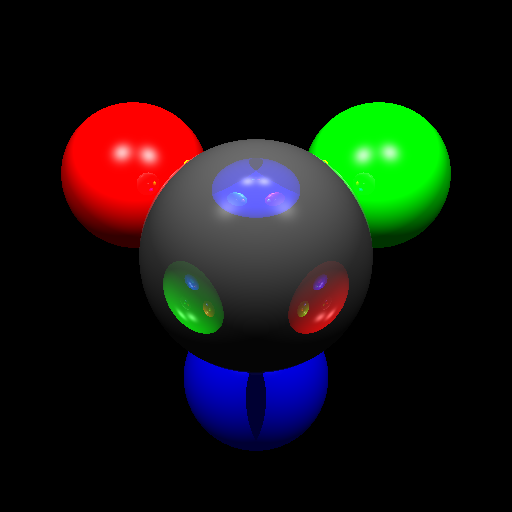

In [246]:
res